In [1]:
from jax import config
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import gpjax as gpx

# Use float64 for more stable GP math
config.update("jax_enable_x64", True)

/Users/sarac/Downloads/gpjax/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Simulate noisy 1D data
key = jr.key(123)
n = 50
noise = 0.2

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)

true_fun = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = true_fun(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 300).reshape(-1, 1)
ytest = true_fun(xtest)

In [3]:
# 2. Define GP prior
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [4]:
# 3. Likelihood and posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [5]:
# 4. Optimise hyperparameters by maximising log marginal likelihood
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
    trainable=gpx.parameters.Parameter,
)

Optimization terminated successfully.
         Current function value: 24.620112
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16


In [6]:
# 5. Predict at test points
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

mean = predictive_dist.mean
std = jnp.sqrt(predictive_dist.variance)

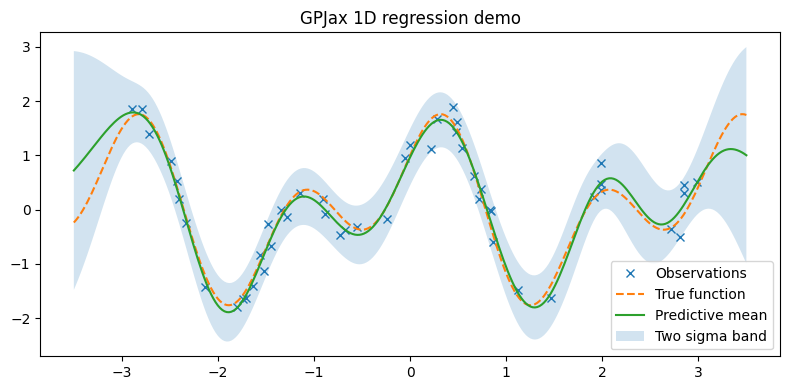

In [7]:
# 6. Plot data, true function, and GP fit
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y, "x", label="Observations")
ax.plot(xtest, ytest, linestyle="--", label="True function")
ax.plot(xtest, mean, label="Predictive mean")
ax.fill_between(
    xtest.squeeze(),
    (mean - 2 * std).squeeze(),
    (mean + 2 * std).squeeze(),
    alpha=0.2,
    label="Two sigma band",
)
ax.legend()
ax.set_title("GPJax 1D regression demo")
plt.tight_layout()
plt.show()

##### Bloom Field Example in 2D

In [ ]:
# 1. Define a "bloom field" in 2D
def true_field(x):
    """
    x has shape (N, 2), columns are [x_coord, y_coord].
    Returns a synthetic scalar field with two "blooms".
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    #Gaussian Blooms
    r1 = jnp.exp(-0.5 * ((x1 + 0.5) ** 2 + (x2 + 0.5) ** 2) / 0.2 ** 2)
    r2 = 1.3 * jnp.exp(-0.5 * ((x1 - 0.8) ** 2 + (x2 - 0.5) ** 2) / 0.3 ** 2)

    return r1 + r2


In [9]:
# 2. Create a grid over the square region
n_grid = 50
x1_vals = jnp.linspace(-2.0, 2.0, n_grid)
x2_vals = jnp.linspace(-2.0, 2.0, n_grid)
X1g, X2g = jnp.meshgrid(x1_vals, x2_vals)
X_grid = jnp.stack([X1g.ravel(), X2g.ravel()], axis=1)  # shape (n_grid^2, 2)

# True field values
field_true = true_field(X_grid)


In [11]:
# 3. Sample a small set of noisy observations from this field
key = jr.key(0)
n_samples = 80
key, subkey1, subkey2 = jr.split(key, 3)

idx = jr.choice(subkey1, X_grid.shape[0], shape=(n_samples,), replace=False)
X_train = X_grid[idx]
y_clean = field_true[idx]

noise = 0.05
y_train = y_clean + noise * jr.normal(subkey2, shape=y_clean.shape)

# Make y 2D: shape (N, 1)
y_train = y_train.reshape(-1, 1)

D = gpx.Dataset(X=X_train, y=y_train)

In [12]:
# 4. Define GP prior in 2D and likelihood
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [13]:
# 5. Optimise hyperparameters
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
    trainable=gpx.parameters.Parameter,
)

Optimization terminated successfully.
         Current function value: -39.263882
         Iterations: 16
         Function evaluations: 24
         Gradient evaluations: 24


In [14]:
# 6. Predict over the whole grid
latent_dist = opt_posterior.predict(X_grid, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

mean = predictive_dist.mean.reshape(n_grid, n_grid)
std = jnp.sqrt(predictive_dist.variance).reshape(n_grid, n_grid)
field_true_img = field_true.reshape(n_grid, n_grid)

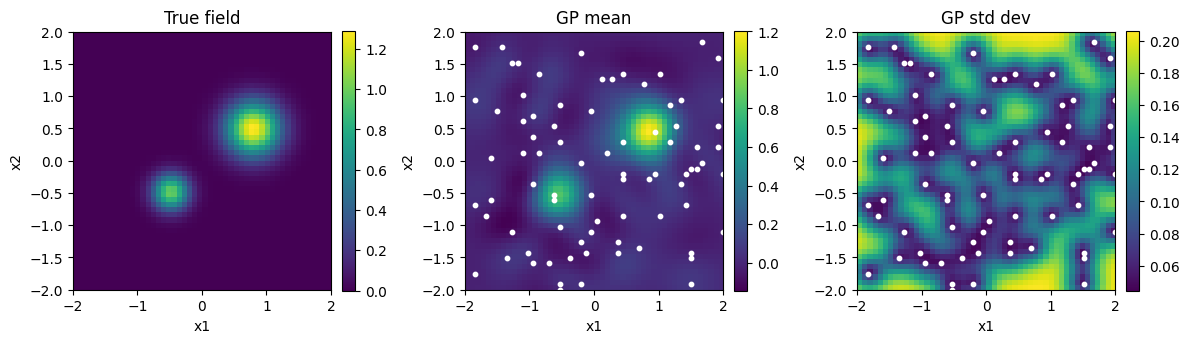

In [15]:
# 7. Plot true field, GP mean, and GP std deviation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im0 = axes[0].imshow(
    field_true_img,
    origin="lower",
    extent=[x1_vals[0], x1_vals[-1], x2_vals[0], x2_vals[-1]],
)
axes[0].set_title("True field")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(
    mean,
    origin="lower",
    extent=[x1_vals[0], x1_vals[-1], x2_vals[0], x2_vals[-1]],
)
axes[1].scatter(X_train[:, 0], X_train[:, 1], s=10, c="white")
axes[1].set_title("GP mean")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(
    std,
    origin="lower",
    extent=[x1_vals[0], x1_vals[-1], x2_vals[0], x2_vals[-1]],
)
axes[2].scatter(X_train[:, 0], X_train[:, 1], s=10, c="white")
axes[2].set_title("GP std dev")
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()